In [1]:
import numpy as np
data = np.load("sgd_1024_trajs_2.npz", allow_pickle=True)

In [2]:
data.keys()

KeysView(<numpy.lib.npyio.NpzFile object at 0x1062078d0>)

In [3]:
theta_hat_histories = data['theta_hat_histories']
theta_bar_histories = data['theta_bar_histories']
theta_true = data['theta_true']

In [12]:
theta_true

array([ 1. ,  1. , -0.1, -0.1, -0.1])

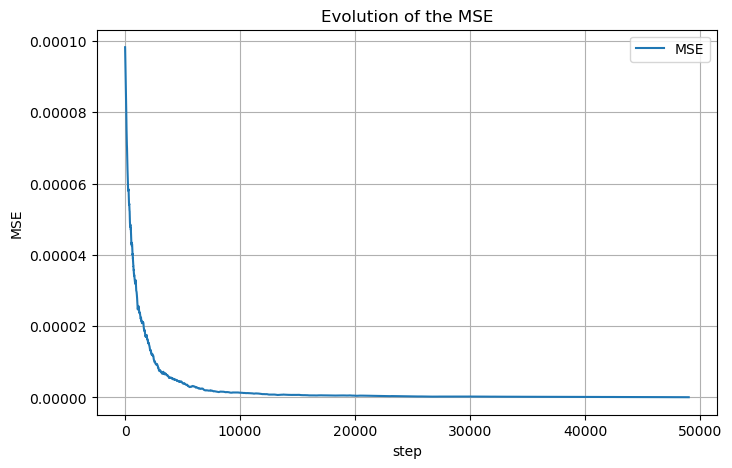

In [4]:
import matplotlib.pyplot as plt

mse = np.sum((theta_bar_histories[0][1000:] - theta_true)**2, axis=1) # shape: (n_trajectories, n_steps)
mse.shape
# Строим график
plt.figure(figsize=(8,5))
plt.plot(mse, label="MSE")
plt.xlabel("step")
plt.ylabel("MSE")
plt.title("Evolution of the MSE")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
data = np.load("theta_bar_boot_1024_2.npz", allow_pickle=True)

In [6]:
theta_bar_boot_mean = data['theta_bar_boot_mean']

In [7]:
theta_bar_boot_mean_ = theta_bar_boot_mean[:,:,4,:]

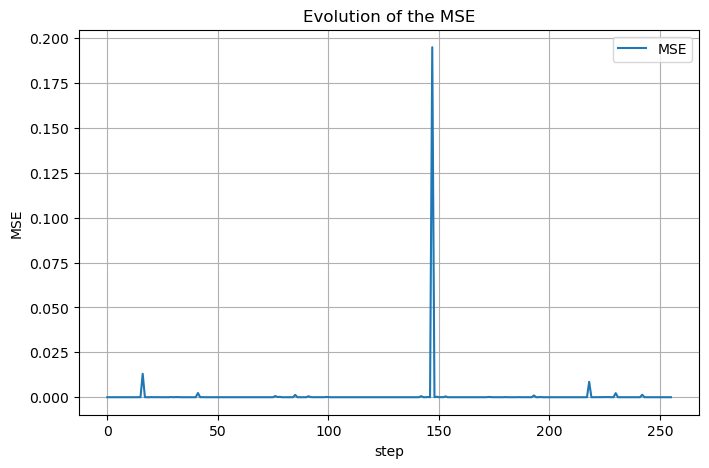

In [35]:
import matplotlib.pyplot as plt

mse = np.sum((theta_bar_boot_mean[0,:,-1,:] - theta_bar_histories[0,-1,:])**2, axis=1) # shape: (n_trajectories, n_steps)
mse.shape
# Строим график
plt.figure(figsize=(8,5))
plt.plot(mse, label="MSE")
plt.xlabel("step")
plt.ylabel("MSE")
plt.title("Evolution of the MSE")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
def cov_prob_1(conf, i):
    theta_bar_boot_mean_ = theta_bar_boot_mean[:,:,i,:]
    n_trajectories, N_boot, p = theta_bar_boot_mean_.shape

    # Генерируем случайный единичный вектор на p-мерной сфере
    rng = np.random.default_rng(12345)
    u = rng.normal(size=p)
    u /= np.linalg.norm(u)  # нормируем

    # Массив для результатов: True/False для каждой траектории
    theta_in_interval = np.zeros(n_trajectories, dtype=bool)

    for traj in range(n_trajectories):
        # Проекции всех бутстрэп-векторов на u
        projections = theta_bar_boot_mean_[traj] @ u  # shape (N_boot,)

        alpha = (100 - conf)
        lower = np.percentile(projections, alpha / 2)       
        upper = np.percentile(projections, 100 - alpha / 2) 

        # Проверяем, попадает ли проекция theta_true на u в интервал
        true_proj = theta_true @ u
        theta_in_interval[traj] = int((lower <= true_proj <= upper))

    # Считаем долю траекторий, для которых theta_true попадает в интервал
    coverage = np.mean(theta_in_interval)
    return coverage

In [32]:
from scipy.stats import norm
def cov_prob_2(conf, i):
    theta_bar_boot_mean_ = theta_bar_boot_mean[:,:,i,:]
    theta_bar = theta_bar_histories[:,(i+1)*10000,:]
    n_trajectories, N_boot, p = theta_bar_boot_mean_.shape

    # Генерируем случайный единичный вектор на p-мерной сфере
    rng = np.random.default_rng(12345)
    u = rng.normal(size=p)
    u /= np.linalg.norm(u)  # нормируем

    # Массив для результатов: True/False для каждой траектории
    theta_in_interval = np.zeros(n_trajectories, dtype=bool)

    for traj in range(n_trajectories):
        # Проекции всех бутстрэп-векторов на u
        projections = np.sqrt((i+1)*10000 +1)*((theta_bar_boot_mean_[traj]-theta_bar[traj]) @ u)  
        var = np.var(projections)
        std = np.sqrt(var)
        print(((theta_bar_boot_mean_[traj]-theta_bar[traj]) @ u).max())

        alpha = 1 - conf/100
        z = norm.ppf(1 - alpha/2)
        

        lower = theta_bar[traj] @ u - z * std/ np.sqrt((i+1)*10000 +1)
        upper = theta_bar[traj] @ u + z * std/ np.sqrt((i+1)*10000 +1)

        # Проверяем, попадает ли проекция theta_true на u в интервал
        true_proj = theta_true @ u
        theta_in_interval[traj] = int((lower <= true_proj <= upper))

    # Считаем долю траекторий, для которых theta_true попадает в интервал
    coverage = np.mean(theta_in_interval)
    return coverage

In [33]:
import pandas as pd

# твои данные
confs = [95, 90, 80]
lengths = [10000, 20000, 30000, 40000, 50000]

# строим таблицу
table = pd.DataFrame(index=lengths, columns=confs)

for j, length in enumerate(lengths, start=0):   # индексы начинаются с 1
    for conf in confs:
        table.loc[length, conf] = cov_prob_1(conf, j)

# красиво переименуем столбцы
table.index.name = "Trajectory length"
table.columns = [f"{c/100:.2f}" for c in confs]  # 95 -> "0.95"

print(table)

                  0.95 0.90 0.80
Trajectory length               
10000              1.0  1.0  1.0
20000              1.0  1.0  1.0
30000              1.0  1.0  1.0
40000              1.0  1.0  1.0
50000              1.0  1.0  1.0


In [34]:
import pandas as pd

# твои данные
confs = [95, 90, 80]
lengths = [10000, 20000, 30000, 40000, 50000]

# строим таблицу
table = pd.DataFrame(index=lengths, columns=confs)

for j, length in enumerate(lengths, start=0):   # индексы начинаются с 1
    for conf in confs:
        table.loc[length, conf] = cov_prob_2(conf, j)

# красиво переименуем столбцы
table.index.name = "Trajectory length"
table.columns = [f"{c/100:.2f}" for c in confs]  # 95 -> "0.95"

print(table)

0.2567487172692729
1.8272719725670825
0.9078891149872419
11.788227883516143
2.844427026616027
3.204564967851925
0.3901561155170773
1.1288992845359114
2.5805379388009104
0.11489742022899604
1.108109514510395
8.49428223184768
0.4420525321240343
2.2723252038338053
7.380746875194824
323.27151946148626
1.2777351492666442
0.7874995589473305
1.3676908292821799
0.6810513142437812
0.3133813445384942
2.850085685204576
4.83340258614822
0.19962688049418198
0.3803000748667358
4.263567939226198
251.42324417803565
2.2167230823525994
0.1148578532482467
6.029235568639521
0.697214262316233
0.031189332403864376
2.470740481372263
7.308517678295424
13.525194987203166
2.8681281204342612
1.2710023661520051
0.4500085182657254
63.74474384264963
0.7902464055115892
1.9680582946610232
53.24652377293809
1.2617435689884027
2.0136920798817384
0.7858614586165399
5.032090834302814
0.29977554135319584
156.6093572561112
7.1345952807072806
1.1199432808189709
11.563278497060818
1.7581759336687297
1.803750014801303
5.21196

0.6024898316183127
3.6591262032531118
0.4501771079644389
0.259522179715534
0.18140796592507055
1.0341575836596926
1.4878742987776752
3.720703527210209
0.15954800577350575
0.9179589985808477
1.093905386157638
0.09609920247866312
0.10499705021275822
2.9355013745747423
2.8463535305683694
0.8467216314455905
0.37257817593951686
4.527692736531468
0.5500190146605822
0.30792132589708854
5.269023131570051
2.274736973423747
0.31864955678075746
1.492178080107127
1.3404508484479938
0.14538328875767165
0.3017717228386377
0.07074082080564528
0.4032371415297584
1.6042405924552676
0.8231928775262918
552.9808359217493
3.571034875201519
0.38885155407953476
0.5060277950798708
0.4801506518713785
0.31380379411752657
0.22337462115215326
3.089318359167886
0.3160110105335548
0.19520016259910347
0.18578538202767317
6.775033404350935
0.548404927198131
4.511641116635003
0.7344805319730235
0.40423398014941525
3.486557336518013
3.2378745356628853
0.5407559965511628
4.040101196779474
48.3078914281468
75.56415333933

1.089390624239728
7.181924997521702
1.8976064302125006
2.714178228714994
4.085899775626985
0.8983885974922314
60.701887177269384
0.8303126114113376
0.04268066517533913
1.380391543743168
1.8787786467237853
6.115644041972582
2.711588677431324
0.33662350716161743
16.005432569391402
0.016298908909173297
0.21114239789664807
2.2113661620822076
0.20438488604275948
1.911870870724817
0.25401779169633953
1.07602706048313
0.07841122629672716
0.14597675765094378
0.12654765965051393
0.08148589450591506
2.044094199202135
0.11599481221403392
0.3008277813724968
0.21648943132209075
0.9461356768599096
2.021437942758784
0.3416909919031048
0.19359533180194907
0.5760823935888155
8.167173525343884
0.4128347160156715
1.1194431122231328
1.3851484126590627
1.6360150113738434
40.24847881025547
2.63334115322358
12.629190785547062
3.9809398165934096
0.19786888812488473
0.6741561562035444
0.8232223296893826
0.6697673866950881
0.2940349182153407
0.2022944335637118
0.6463904146918016
0.14724858368228727
0.6022257246

0.23792818666494345
0.7344520400865873
0.16399303438984222
0.36101681821822446
0.15067544100844066
0.47715085822735026
0.3741996273515765
0.5920632619368981
6.843276582310742
2.4305289910466907
0.13679634880365463
0.7034302314812277
0.5097298763706546
3.2764071409384736
0.19136713392403945
0.9044350818354221
0.1512507193830386
0.43877584753679444
0.9343053883302697
1.5656808636044213
1.500616650641608
0.2835609286740532
1.0661188560727684
5.837667658415819
0.055440668524978066
13.822819468388456
0.9676113848894857
0.07692288078232538
55.49643254092279
1.19795961330226
0.3043802760327916
0.11142439845318136
0.6335558915524419
7.921522436877847
2.141279103987985
0.6315764460991944
0.019255425522734276
0.6175050143569676
0.3357477536455902
0.10793366395828219
2.2039567786369894
0.07188596447174281
0.11932386066874401
0.4389111944551641
0.555197874784121
4.637245479297059
402.902781088993
0.08493556358720374
0.4979901757268267
0.022815274047097777
1.9803435568565635
0.9831140098106083
0.18

6.160823310943546
0.23095022214560068
10.518525450462487
0.029938229118408547
0.1275128636923165
1.2243251511462945
0.45775648668692875
0.012699879019894528
0.03924519426967358
0.0833728258660119
1.0448909598440759
0.13720418839614434
448.54675195912984
0.04851920468178031
6.382541980798275
1.0050614445489272
0.32925424757714805
1.4763846011367576
0.4065902128130016
1.8338234957975605
0.9082556902704662
0.19668094526347185
0.1294517556750073
1.2289924022534486
0.10000769508322709
0.13281212978540619
0.6887365521893143
4.427744719150536
0.8196235296371726
0.18624962161884148
1.181472176662361
0.5017548429155478
1.8928307588794444
14.371653235157089
9.99537924874838
0.1321212794707198
1.3322564479396226
1.067826905816152
0.38817076983004184
0.05909880710099107
0.6064353397788819
0.38159928072560717
0.17965227480696166
0.3086545843105956
0.33258981268768045
46.107615849634165
0.031104474913467232
0.6472492099429201
2.0484550216579076
0.5878629365924551
1.5207857979404809
0.211583070996818

In [13]:
cov_prob_2(95, 0)

0.912109375

In [74]:
def batch_mean(theta_hat_histories, b_n):
    """
    Compute the mean over sliding windows of size b_n along the 2nd axis (iterations),
    in a memory-efficient way.

    Parameters:
        PR_V : np.ndarray, shape (N_traj, N_iters, N_s)
        b_n : int, batch window size

    Returns:
        BM_V : np.ndarray, shape (N_traj, N_iters - b_n + 1, N_s)
    """
    N_traj, N_iters, N_s = theta_hat_histories.shape
    BM_V = np.empty((N_traj, N_iters - b_n+1, N_s), dtype=theta_hat_histories.dtype)

    # for i in tqdm(range(N_iters - b_n + 1), desc="Computing batch means"):
    #     BM_V[:, i, :] = PR_V[:, i:i + b_n, :].mean(axis=1)
    cur_bm = theta_hat_histories[:,0:b_n,:].mean(axis=1)
    for i in tqdm(range(N_iters-b_n), desc="Computing batch means"):
        BM_V[:, i, :] = cur_bm
        cur_bm += (theta_hat_histories[:, b_n+i,:]-theta_hat_histories[:, i,:])/b_n
    BM_V[:, -1, :]=cur_bm
    return BM_V

def cov_prob_3(conf, b_n, BM_V, theta_bar_histories, i):
    n_trajectories, N, p = theta_bar_histories.shape
    rng = np.random.default_rng(12345)
    u = rng.normal(size=p)
    u /= np.linalg.norm(u)  # нормируем
    theta_in_interval = np.zeros(n_trajectories, dtype=bool)
    for traj in tqdm(range(n_trajectories)):
        hat_sigma =  (((BM_V[traj]-theta_bar_histories[traj,-1,:])@u)**2).sum() * ((b_n)/(50001-b_n+1))
        std = np.sqrt(hat_sigma)
        alpha = 1 - conf/100
        z = norm.ppf(1 - alpha/2)

        lower = theta_bar_histories[traj,(i+1)*10000,:] @ u - z * std/ np.sqrt((i+1)*10000+1)
        upper = theta_bar_histories[traj,(i+1)*10000,:] @ u + z * std/ np.sqrt((i+1)*10000+1)

        # Проверяем, попадает ли проекция theta_true на u в интервал
        true_proj = theta_true @ u
        theta_in_interval[traj] = int((lower <= true_proj <= upper))
    coverage = np.mean(theta_in_interval)
    return coverage

In [80]:
BM_V = batch_mean(theta_hat_histories, 50)

Computing batch means: 100%|███████████| 49951/49951 [00:02<00:00, 23197.31it/s]


In [81]:
cov_prob_3(95, 50,BM_V, theta_bar_histories, 4)

100%|██████████████████████████████████████| 1024/1024 [00:01<00:00, 596.57it/s]


0.8486328125

In [51]:
50001**(0.1)

2.950515286302581

In [49]:
(1-0.85)/2

0.07500000000000001